# Análisis Exploratorio de Imágenes

Este notebook realiza el análisis exploratorio de las tres imágenes del comedor que serán fusionadas en un panorama.

## Objetivos

1. Cargar y visualizar las imágenes originales
2. Analizar las características de cada imagen
3. Experimentar con diferentes detectores de características (SIFT, ORB, AKAZE)
4. Comparar la distribución y calidad de los keypoints detectados
5. Analizar las correspondencias entre pares de imágenes


In [1]:
# Importar librerías necesarias
import sys
sys.path.append('..')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Importar módulos propios
from src import utils
from src.feature_detection import FeatureDetector, DetectorType, compare_detectors
from src.matching import FeatureMatcher, MatcherType, get_matched_points, compute_match_statistics

# Configuración de matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("Librerías importadas correctamente")  


Librerías importadas correctamente


## 1. Cargar Imágenes Originales

Cargamos las tres imágenes del comedor que fueron capturadas desde diferentes perspectivas.


Número de imágenes encontradas: 3
  - IMG01.jpg
  - IMG02.jpg
  - IMG03.jpg
Imagen IMG01.jpg: (4032, 3024, 3)
Imagen IMG02.jpg: (4032, 3024, 3)
Imagen IMG03.jpg: (3024, 4032, 3)


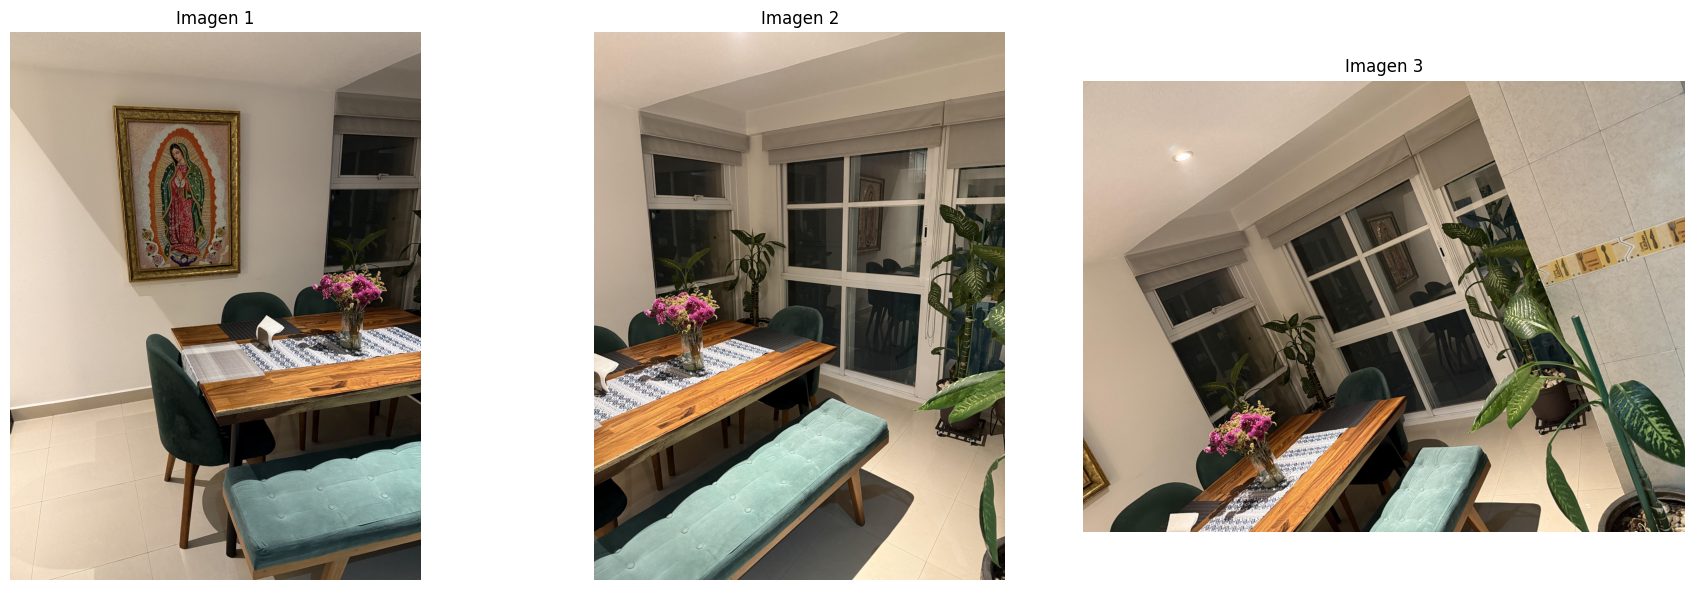

In [2]:
# Cargar imágenes
image_dir = Path('../data/original')
image_paths = sorted(list(image_dir.glob('*.jpg')))

print(f"Número de imágenes encontradas: {len(image_paths)}")
for path in image_paths:
    print(f"  - {path.name}")

# Cargar imágenes
images = []
for path in image_paths:
    img = utils.load_image(str(path))
    images.append(img)
    print(f"Imagen {path.name}: {img.shape}")

# Visualizar imágenes originales
utils.visualize_images(
    images,
    titles=[f'Imagen {i+1}' for i in range(len(images))],
    figsize=(18, 6),
    save_path='../results/figures/01_original_images.png'
)


## 2. Análisis de Características con Diferentes Detectores

Comparamos tres detectores diferentes (SIFT, ORB, AKAZE) para ver cuál funciona mejor con nuestras imágenes.


Comparando detectores en Imagen 1...
ESTADÍSTICAS DE DETECTORES

SIFT:
  - Keypoints detectados: 61930
  - Respuesta promedio: 0.0317 (±0.0169)
  - Tamaño promedio: 3.02 (±5.99)
  - Ángulo promedio: 181.69° (±102.72°)

ORB:
  - Keypoints detectados: 2000
  - Respuesta promedio: 0.0050 (±0.0028)
  - Tamaño promedio: 53.88 (±23.31)
  - Ángulo promedio: 181.22° (±102.76°)

AKAZE:
  - Keypoints detectados: 18397
  - Respuesta promedio: 0.0041 (±0.0045)
  - Tamaño promedio: 8.84 (±7.99)
  - Ángulo promedio: 182.33° (±103.14°)


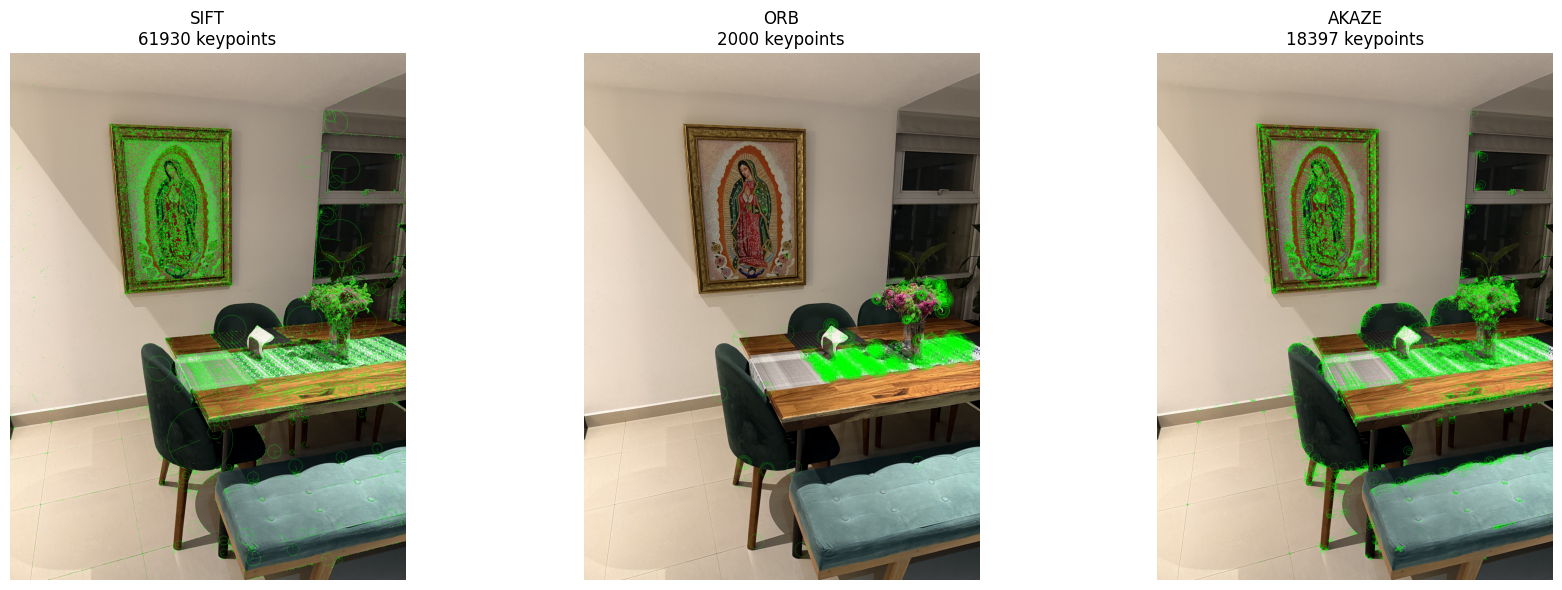

In [3]:
# Comparar detectores en la primera imagen
print("Comparando detectores en Imagen 1...")
results = compare_detectors(images[0])

# Mostrar estadísticas

print("ESTADÍSTICAS DE DETECTORES")

for detector_name, data in results.items():
    info = data['info']
    print(f"\n{detector_name}:")
    print(f"  - Keypoints detectados: {info['count']}")
    print(f"  - Respuesta promedio: {info['mean_response']:.4f} (±{info['std_response']:.4f})")
    print(f"  - Tamaño promedio: {info['mean_size']:.2f} (±{info['std_size']:.2f})")
    print(f"  - Ángulo promedio: {info['mean_angle']:.2f}° (±{info['std_angle']:.2f}°)")

# Visualizar keypoints
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (detector_name, data) in zip(axes, results.items()):
    img_with_kp = utils.draw_keypoints(images[0], data['keypoints'])
    ax.imshow(img_with_kp)
    ax.set_title(f'{detector_name}\n{data["info"]["count"]} keypoints')
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/02_detector_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Análisis de Correspondencias entre Pares de Imágenes

Analizamos las correspondencias entre imágenes consecutivas usando el mejor detector.


In [4]:
# Usar SIFT como detector principal (generalmente el más robusto)
detector = FeatureDetector(DetectorType.SIFT)

# Detectar características en todas las imágenes
print("Detectando características en todas las imágenes...")
all_keypoints = []
all_descriptors = []

for i, img in enumerate(images):
    kp, desc = detector.detect_and_compute(img)
    all_keypoints.append(kp)
    all_descriptors.append(desc)
    print(f"Imagen {i+1}: {len(kp)} keypoints detectados")



Detectando características en todas las imágenes...
Imagen 1: 61930 keypoints detectados
Imagen 2: 37273 keypoints detectados
Imagen 3: 33332 keypoints detectados


In [5]:
# Emparejar imágenes consecutivas
matcher = FeatureMatcher(MatcherType.BF, descriptor_type='SIFT')


print("ANÁLISIS DE CORRESPONDENCIAS")


pair_matches = []
for i in range(len(images) - 1):
    print(f"\nEmparejando Imagen {i+1} con Imagen {i+2}...")
    
    # Match con ratio test
    matches = matcher.match_robust(all_descriptors[i], all_descriptors[i+1], ratio=0.75)
    pair_matches.append(matches)
    
    # Estadísticas
    stats = compute_match_statistics(matches, all_keypoints[i], all_keypoints[i+1])
    
    print(f"  - Matches encontrados: {stats['count']}")
    print(f"  - Distancia promedio: {stats['mean_distance']:.2f}")
    print(f"  - Distancia mínima: {stats['min_distance']:.2f}")
    print(f"  - Distancia máxima: {stats['max_distance']:.2f}")


ANÁLISIS DE CORRESPONDENCIAS

Emparejando Imagen 1 con Imagen 2...
  - Matches encontrados: 5795
  - Distancia promedio: 135.88
  - Distancia mínima: 31.91
  - Distancia máxima: 270.52

Emparejando Imagen 2 con Imagen 3...
  - Matches encontrados: 6129
  - Distancia promedio: 134.87
  - Distancia mínima: 22.76
  - Distancia máxima: 261.24



Visualizando matches: Imagen 1 ↔ Imagen 2


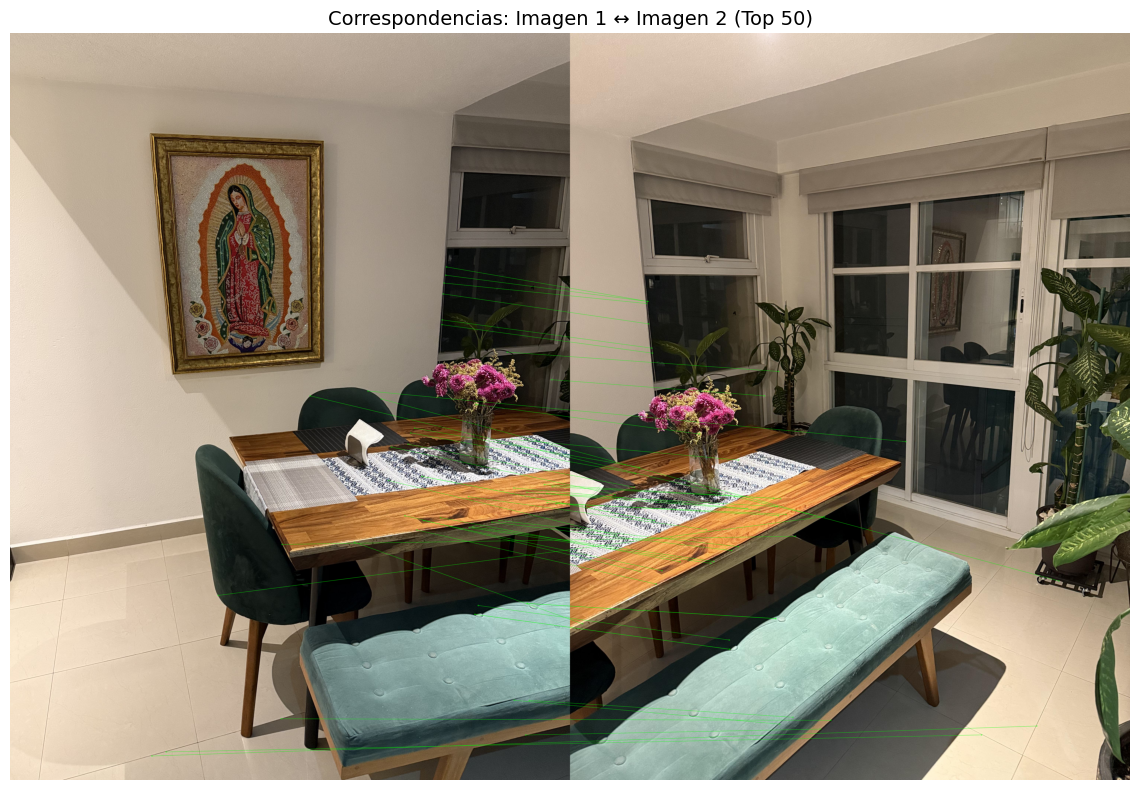


Visualizando matches: Imagen 2 ↔ Imagen 3


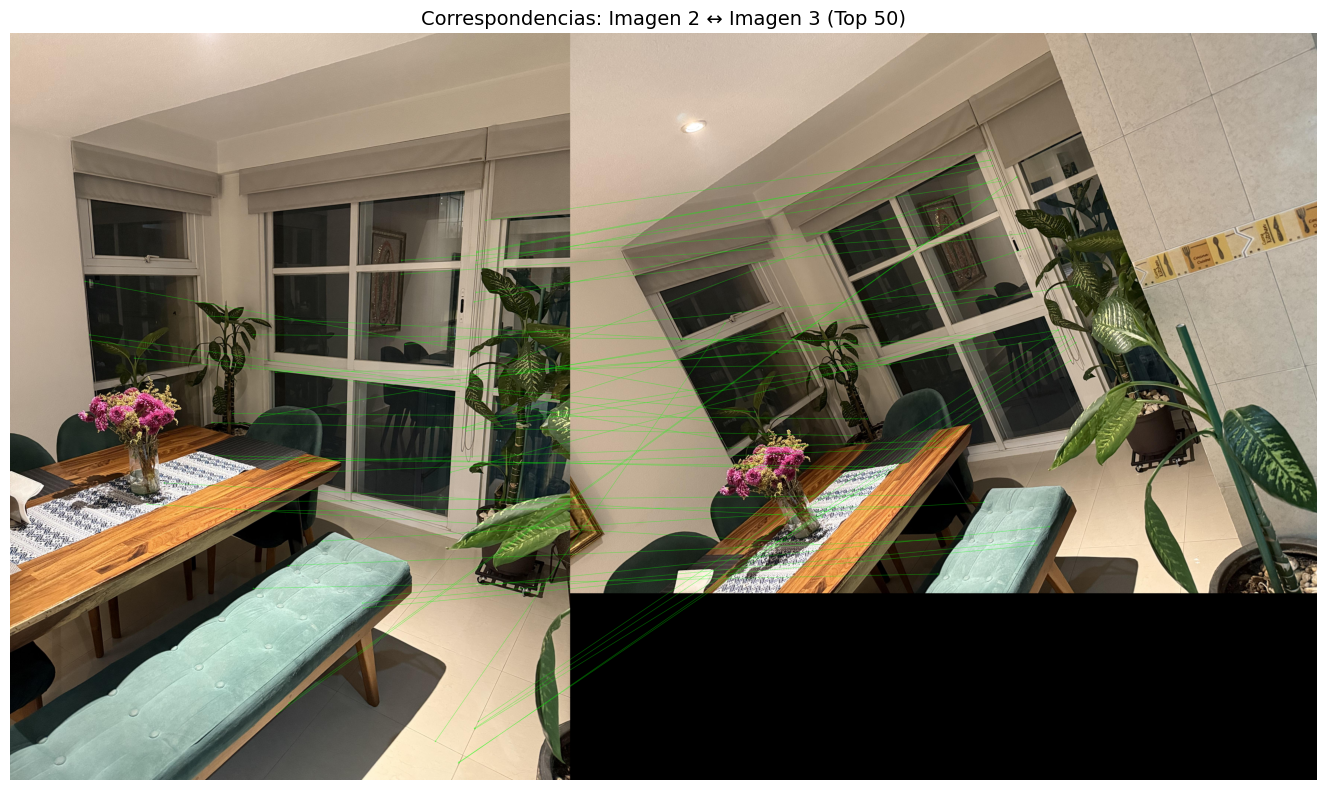

In [6]:
# Visualizar matches entre pares de imágenes
for i in range(len(images) - 1):
    print(f"\nVisualizando matches: Imagen {i+1} ↔ Imagen {i+2}")
    
    # Dibujar top 50 matches
    img_matches = utils.draw_matches(
        images[i], all_keypoints[i],
        images[i+1], all_keypoints[i+1],
        pair_matches[i], num_matches=50
    )
    
    plt.figure(figsize=(18, 8))
    plt.imshow(img_matches)
    plt.title(f'Correspondencias: Imagen {i+1} ↔ Imagen {i+2} (Top 50)', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'../results/figures/03_matches_img{i+1}_to_img{i+2}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


## 4. Análisis de Distribución de Keypoints

Analizamos cómo se distribuyen los keypoints en cada imagen para detectar posibles problemas.


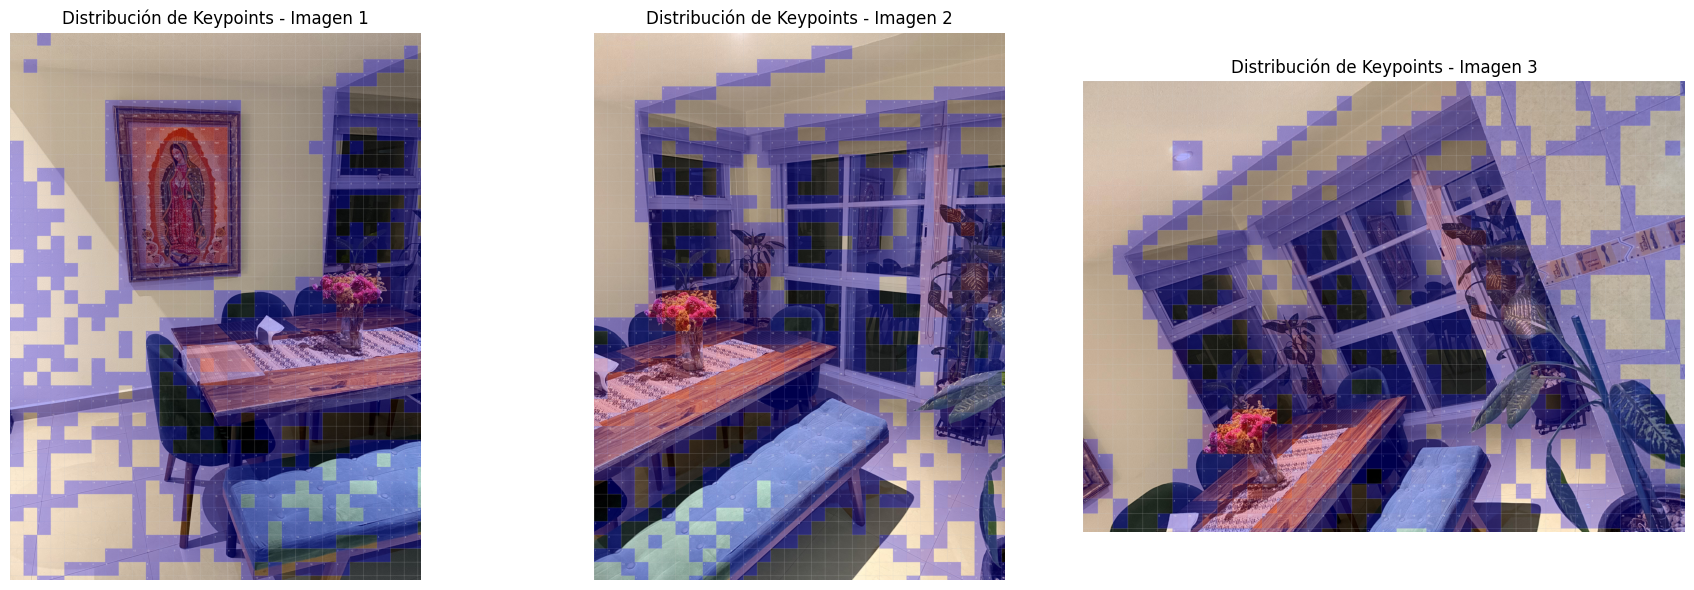


La intensidad del color indica la densidad de keypoints en cada región.


In [7]:
# Visualizar distribución de keypoints
from src.feature_detection import visualize_keypoint_distribution

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (img, kp, ax) in enumerate(zip(images, all_keypoints, axes)):
    dist_viz = visualize_keypoint_distribution(img, kp, grid_size=100)
    ax.imshow(dist_viz)
    ax.set_title(f'Distribución de Keypoints - Imagen {i+1}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/04_keypoint_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLa intensidad del color indica la densidad de keypoints en cada región.")


## 5. Conclusiones del Análisis Exploratorio

### Resumen de hallazgos:

1. **Detector seleccionado**: SIFT parece ser el más robusto para estas imágenes
2. **Número de correspondencias**: Se encontraron suficientes matches entre imágenes consecutivas
3. **Calidad de matches**: Las distancias promedio son razonables
4. **Distribución de keypoints**: Los keypoints están bien distribuidos en las regiones con textura

